In [2]:
import numpy as np
import xgcm
from xgcm import Grid
from xhistogram.xarray import histogram
import xarray as xr
import xroms
from scipy import signal
import matplotlib.pyplot as plt
import glob

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo

plt.rcParams.update({'font.size': 14})

### Open the hourly and 10-minute history files

In [3]:
paths = ['/scratch/user/dylan.schlichting/TXLA_Outputs/nested_10min/ocean_his_child_00001.nc',
         '/scratch/user/dylan.schlichting/TXLA_Outputs/nested_10min/ocean_his_child_00002.nc',
         '/scratch/user/dylan.schlichting/TXLA_Outputs/nested_10min/ocean_his_child_00003.nc',
         '/scratch/user/dylan.schlichting/TXLA_Outputs/nested_10min/ocean_his_child_00004.nc',
         '/scratch/user/dylan.schlichting/TXLA_Outputs/nested_10min/ocean_his_child_00005.nc',
        ]
paths1 = ['/scratch/user/dylan.schlichting/TXLA_Outputs/nested_hourly/ocean_his_child_00001.nc',
          '/scratch/user/dylan.schlichting/TXLA_Outputs/nested_hourly/ocean_his_child_00002.nc',
          '/scratch/user/dylan.schlichting/TXLA_Outputs/nested_hourly/ocean_his_child_00003.nc',
        ]

ds_10min = xroms.open_mfnetcdf(paths, 
                                chunks = {'ocean_time':1})
ds_10min, grid_hourly = xroms.roms_dataset(ds_10min, 
                                     Vtransform = None)

ds_hourly = xroms.open_mfnetcdf(paths1, 
                                chunks = {'ocean_time':1})
ds_hourly, grid_10min = xroms.roms_dataset(ds_hourly, 
                                     Vtransform = None)

xislice=slice(50,250) #note tendencies have x+1 stopping points
etaslice=slice(150,350)

#Open tef, tendency terms, and chi for hourly and 10 min history file frequency
tef_hourly = xr.open_dataset('/scratch/user/dylan.schlichting/tef/outputs/transports/xi_50_250_eta_150_350/tef_nested_hourly_xi_50_250_eta_150_350.nc')
tendencies_hourly = xr.open_dataset('/scratch/user/dylan.schlichting/tef/outputs/tendencies/xi_50_250_eta_150_350/tendencies_nested_hourly_xi_50_250_eta_150_350.nc')
chi_hourly = xr.open_dataset('/scratch/user/dylan.schlichting/tef/outputs/mixing/xi_50_250_eta_150_350/dissipation_nested_hourly_xi50250_eta150350.nc')

tef_10min = xr.open_dataset('/scratch/user/dylan.schlichting/tef/outputs/transports/xi_50_250_eta_150_350/tef_nested_10min_xi_50_250_eta_150_350.nc')
tendencies_10min = xr.open_dataset('/scratch/user/dylan.schlichting/tef/outputs/tendencies/xi_50_250_eta_150_350/tendencies_nested_10min_xi_50_250_eta_150_350.nc')
chi_10min = xr.open_dataset('/scratch/user/dylan.schlichting/tef/outputs/mixing/xi_50_250_eta_150_350/dissipation_nested_10min_xi50250_eta150350.nc')

tef_10min_s200 = xr.open_dataset('/scratch/user/dylan.schlichting/tef/outputs/transports/xi_50_250_eta_150_350/tef_nested_10min_xi_50_250_eta_150_350_s200.nc')
chi_10min_s500 = xr.open_dataset('/scratch/user/dylan.schlichting/tef/outputs/mixing/xi_50_250_eta_150_350/dissipation_histogram_10min_xi50250_eta150350_sbin500.nc')


In [4]:
chi_10min_s500

<xarray.Dataset>
Dimensions:         (ocean_time: 720, salt_bin: 500)
Coordinates:
  * ocean_time      (ocean_time) datetime64[ns] 2010-06-15T00:10:00 ... 2010-...
  * salt_bin        (salt_bin) float64 0.04 0.12 0.2 0.28 ... 39.8 39.88 39.96
Data variables:
    histogram_salt  (ocean_time, salt_bin) float64 ...

(29.0, 37.0)

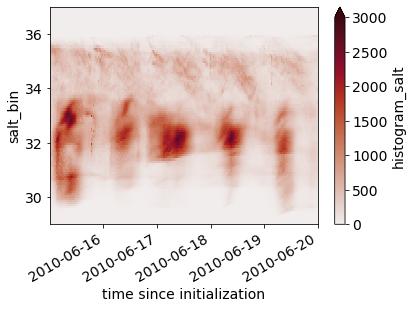

In [5]:
chi_10min_s500.histogram_salt.plot(y = 'salt_bin', cmap = cmo.amp, vmax = 3000)

plt.ylim(29,37)

In [6]:
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                edgecolor='face',
                                facecolor=cfeature.COLORS['land'])
states_provinces = cfeature.NaturalEarthFeature(
                   category='cultural',
                   name='admin_1_states_provinces_lines',
                   scale='10m',
                   facecolor='none')

def Q_faces(ds, xislice, etaslice):
    '''
Computes the volume transport of a tracer along a specified slice of ROMS output. 
Options are currently limited to salt, salt squared. Currently
functionalized for a box. 
-----
Input: 
ds - xarray dataset
grid - xgcm grid
xislice - slice object of desired xi grid points
etaslice -slice object of desired eta grid points
tracer - str Current options are 'salt', 's2', or 
-----
Output:
Qc'variable': Tracer flux at the west, east, north, and south box faces
    '''
    Qu = ds.dz_u*ds.dy_u*ds.u
    Qv = ds.dz_v*ds.dx_v*ds.v

    Qu = Qu.sel(eta_rho = etaslice, xi_u = slice(xislice.start-1, xislice.stop))
    Qv = Qv.sel(eta_v = slice(etaslice.start-1, etaslice.stop), xi_rho = xislice)

    QW = Qu.isel(xi_u = 0) #west
    QE = Qu.isel(xi_u = -1) #east
    QN = Qv.isel(eta_v = -1) #top
    QS = Qv.isel(eta_v = 0) #bottom
    
    QW.name = 'QW'
    QE.name = 'QE'
    QN.name = 'QN'
    QS.name = 'QS'
    
    return QW, QE, QN, QS

QW, QE, QN, QS = Q_faces(ds_hourly, xislice, etaslice)

/scratch/user/dylan.schlichting/.conda/envs/romsenv/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


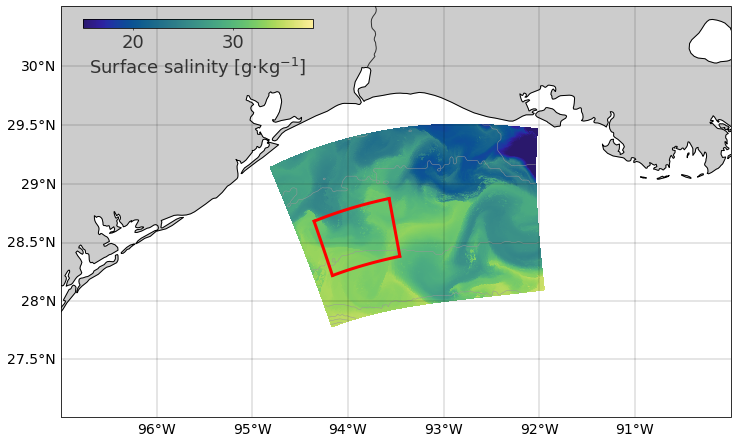

In [8]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=ccrs.Mercator(central_longitude=-85.0))

sal = ds_hourly.salt.sel(ocean_time='2010-06-03-01').isel(s_rho=-1).values
lon_rho = ds_hourly.salt['lon_rho'][:].data
lat_rho = ds_hourly.salt['lat_rho'][:].data
hlevs = [10, 20, 50, 100, 150, 200, 250, 300, 350, 400, 450]  # isobath contour depths

mappable = ax.pcolormesh(lon_rho, lat_rho, sal, 
                         cmap = cmo.haline, 
                         transform = cartopy.crs.PlateCarree(),
                         vmin = 15, vmax = 38)



gl = ax.gridlines(linewidth=0.4, color='black', alpha=0.5, linestyle='-', draw_labels=True)
ax.set_extent([-97, -90, 27, 30.5], ccrs.PlateCarree())
# ax.set_extent([-94.5, -93.5, 27, 30.5], ccrs.PlateCarree())
ax.add_feature(land_10m, facecolor='0.8')
ax.coastlines(resolution='10m')  
ax.add_feature(states_provinces, edgecolor='0.2')
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='0.2')
ax.set_aspect('auto')

cax = fig.add_axes([0.09, 0.91, 0.32, 0.02]) 
cb = fig.colorbar(mappable, cax=cax, orientation='horizontal')
cb.set_label(r'Surface salinity [g$\cdot$kg$^{-1}$]', fontsize=18, color='0.2')
cb.ax.tick_params(labelsize=18, length=2, color='0.2', labelcolor='0.2')

ax.contour(lon_rho, lat_rho, ds_hourly.h, hlevs, colors='0.6', transform=ccrs.PlateCarree(), linewidths=0.5)
ax.tick_params(axis='y', labelsize=18)

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.top_labels = False

ax.plot(QN.lon_v.values, QN.lat_v.values,'-r', transform=ccrs.PlateCarree(), lw = 3)
ax.plot(QS.lon_v.values, QS.lat_v.values,'-r', transform=ccrs.PlateCarree(), lw = 3)
ax.plot(QE.lon_u.values, QE.lat_u.values,'-r', transform=ccrs.PlateCarree(), lw = 3)
ax.plot(QW.lon_u.values, QW.lat_u.values,'-r', transform=ccrs.PlateCarree(), lw = 3)

plt.savefig('../figures/CV_location.jpg', dpi = 200)

### First, let's plot the tracer budgets on their own. Then, we'll slice the hourly output to the same time period as the 10 min range and comapare them. 

#### Start with 10 minute hourly output as our control.

Text(0.5, 1.0, 'Volume Budget - No Surface Forcing')

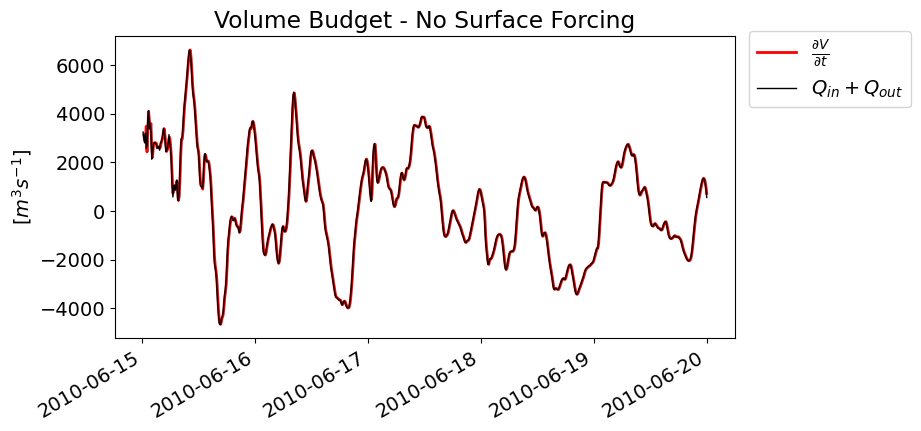

In [6]:
fig = plt.subplots(1, figsize = (8,4), dpi=100)

(tendencies_10min.dVdt).plot(lw=2, color='r', label=r'$\frac{\partial V}{\partial t}$')
tef_10min.voladv.plot(lw=1, color='k', label=r'$Q_{in}+Q_{out}$')

plt.xlabel('')
plt.ylabel(r'[$m^3 s^{-1}$]')
plt.legend(bbox_to_anchor=(1.3, 1.05))
plt.title('Volume Budget - No Surface Forcing')

### Write a short function to do basic statistics. We want to compare the bulk tracer transports and their percent differences.

In [7]:
def bulk_stats(tef, tendencies):
    print(tef.sum().values, 'tef sum [m^3/s]')
    print(tendencies.sum().values, 'tendency sum [m^3/s]')

    pdif = (((tef.sum().values)-(tendencies.sum().values)) \
        /(tendencies.sum().values))*100
    print(pdif, 'Percent difference')

bulk_stats(tef_10min.voladv, tendencies_10min.dVdt)

163439.50825349396 tef sum [m^3/s]
162044.48341445916 tendency sum [m^3/s]
0.8608900529287141 Percent difference


Text(0.5, 1.0, 'Salt Budget - No Surface Forcing')

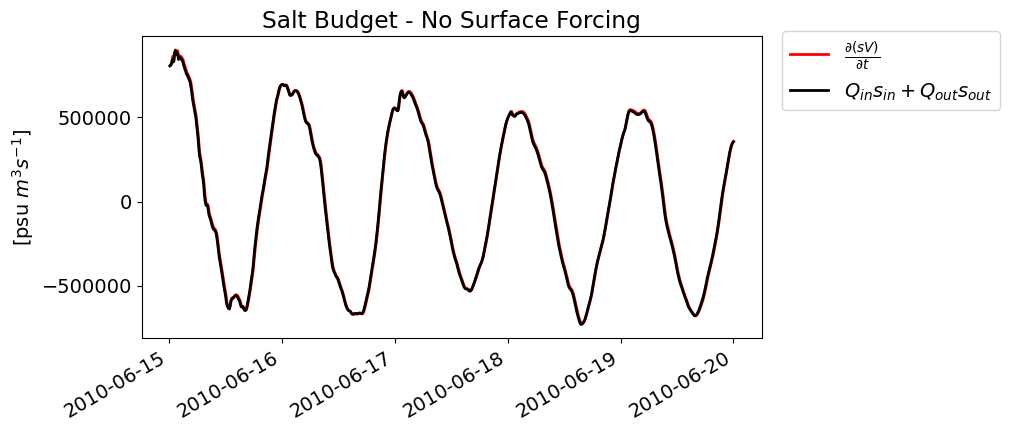

In [8]:
fig = plt.subplots(1, figsize = (8,4), dpi=100)

(tendencies_10min.dsVdt).plot(lw=2, color='r', label=r'$\frac{\partial (sV)}{\partial t}$')
tef_10min.saltadv.plot(lw=2, color='k', label = r'$Q_{in}s_{in}+Q_{out}s_{out}$')

plt.xlabel('')
plt.ylabel(r'[psu $m^3 s^{-1}$]')
plt.legend(bbox_to_anchor=(1.4, 1.05))
plt.title('Salt Budget - No Surface Forcing')

In [9]:
bulk_stats(tef_10min.saltadv, tendencies_10min.dsVdt)

9313331.56129719 tef sum [m^3/s]
11471516.493058264 tendency sum [m^3/s]
-18.813423082005357 Percent difference


Text(0.5, 1.0, 'Salt Squared Budget - No Surface Forcing')

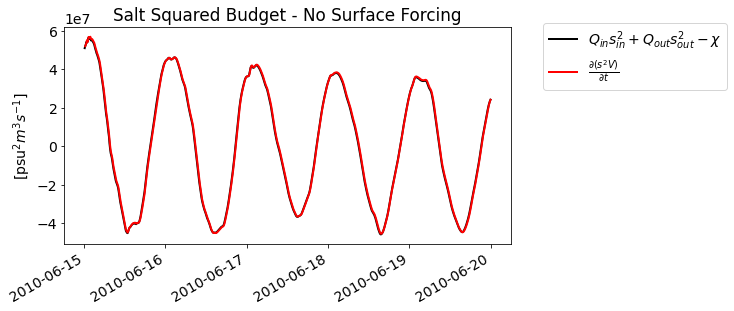

In [10]:
fig = plt.subplots(1, figsize = (8,4))

(tef_10min.ssaltadv-chi_10min.chi).plot(lw=2, color='k', label=r'$Q_{in}s^2_{in}+Q_{out}s^2_{out}-\chi$')
# (tef.ssaltadv).plot(lw=2, color='r', label=r'$Q_{in}s^2_{in}+Q_{out}s^2_{out}$')
tendencies_10min.dssVdt.plot(lw=2, color='r', label=r'$\frac{\partial (s^2V)}{\partial t}$')

plt.xlabel('')
plt.ylabel(r'[psu$^2 m^3 s^{-1}$]')
plt.legend(bbox_to_anchor=(1.5, 1.05))
plt.title('Salt Squared Budget - No Surface Forcing')

In [11]:
bulk_stats(tef_10min.ssaltadv-chi_10min.chi, tendencies_10min.dssVdt)

431652975.6425147 tef sum [m^3/s]
549682638.5935934 tendency sum [m^3/s]
-21.472328697349237 Percent difference


Text(0.5, 1.0, 'Salt Variance Budget - No Surface Forcing')

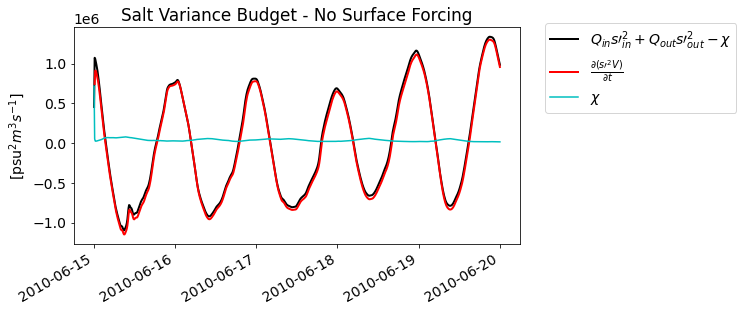

In [12]:
fig = plt.subplots(1, figsize = (8,4))

(tef_10min.svaradv-chi_10min.chi).plot(lw=2, color='k', label=r'$Q_{in}s \prime^2_{in}+Q_{out}s \prime^2_{out}-\chi$')
# (tef.ssaltadv).plot(lw=2, color='r', label=r'$Q_{in}s^2_{in}+Q_{out}s^2_{out}$')
tendencies_10min.dsvardt.plot(lw=2, color='r', label=r'$\frac{\partial (s \prime^2V)}{\partial t}$')
chi_10min.chi.plot(color = 'c', label = r'$\chi$')

plt.xlabel('')
plt.ylabel(r'[psu$^2 m^3 s^{-1}$]')
plt.legend(bbox_to_anchor=(1.5, 1.05))
plt.title('Salt Variance Budget - No Surface Forcing')

In [13]:
bulk_stats(tef_10min.svaradv-chi_10min.chi, tendencies_10min.dsvardt)

-10486698.673285298 tef sum [m^3/s]
-39990028.2254723 tendency sum [m^3/s]
-73.77671599990113 Percent difference


### Look at the hourly budgets

Text(0.5, 1.0, 'Volume Budget - No Surface Forcing')

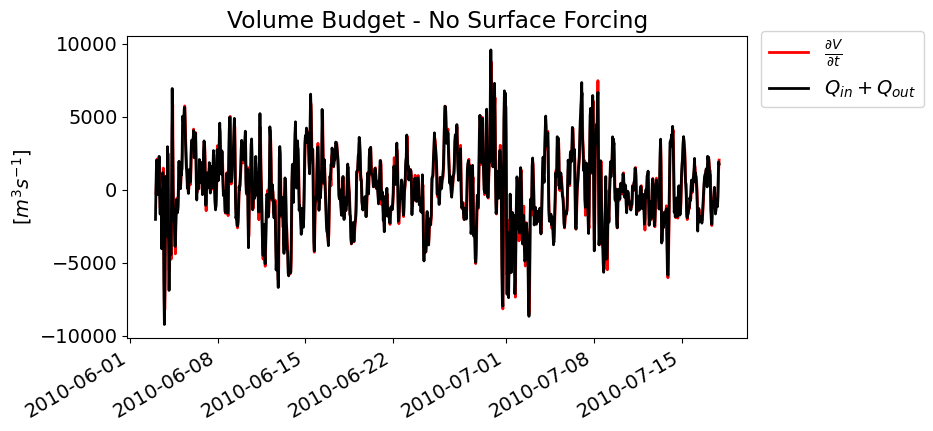

In [14]:
fig = plt.subplots(1, figsize = (8,4), dpi=100)

(tendencies_hourly.dVdt).plot(lw=2, color='r', label=r'$\frac{\partial V}{\partial t}$')
tef_hourly.voladv.plot(lw=2, color='k', label=r'$Q_{in}+Q_{out}$')

plt.xlabel('')
plt.ylabel(r'[$m^3 s^{-1}$]')
plt.legend(bbox_to_anchor=(1.3, 1.05))
plt.title('Volume Budget - No Surface Forcing')

In [15]:
bulk_stats(tef_hourly.voladv, tendencies_hourly.dVdt)

60782.76960411084 tef sum [m^3/s]
62394.714184705925 tendency sum [m^3/s]
-2.5834633616932225 Percent difference


Text(0.5, 1.0, 'Salt Budget - No Surface Forcing')

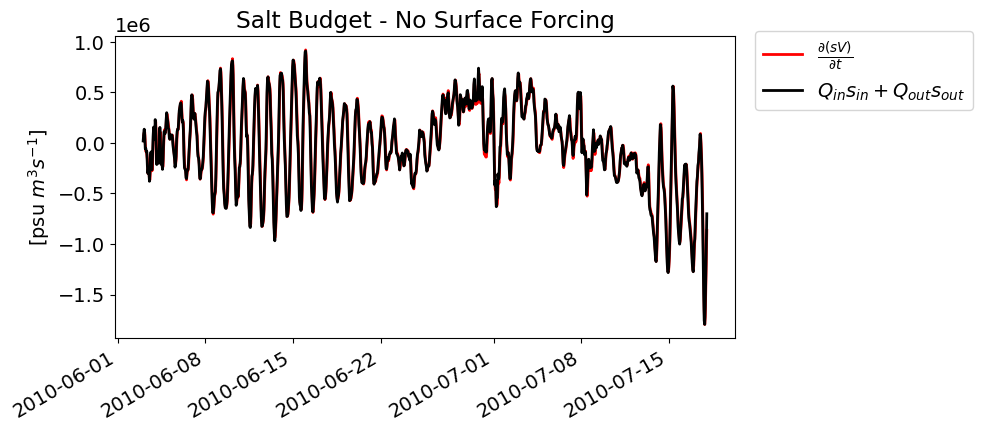

In [16]:
fig = plt.subplots(1, figsize = (8,4), dpi=100)

(tendencies_hourly.dsVdt).plot(lw=2, color='r', label=r'$\frac{\partial (sV)}{\partial t}$')
tef_hourly.saltadv.plot(lw=2, color='k', label = r'$Q_{in}s_{in}+Q_{out}s_{out}$')

plt.xlabel('')
plt.ylabel(r'[psu $m^3 s^{-1}$]')
plt.legend(bbox_to_anchor=(1.4, 1.05))
plt.title('Salt Budget - No Surface Forcing')

Text(0.5, 1.0, 'Salt Squared Budget - No Surface Forcing')

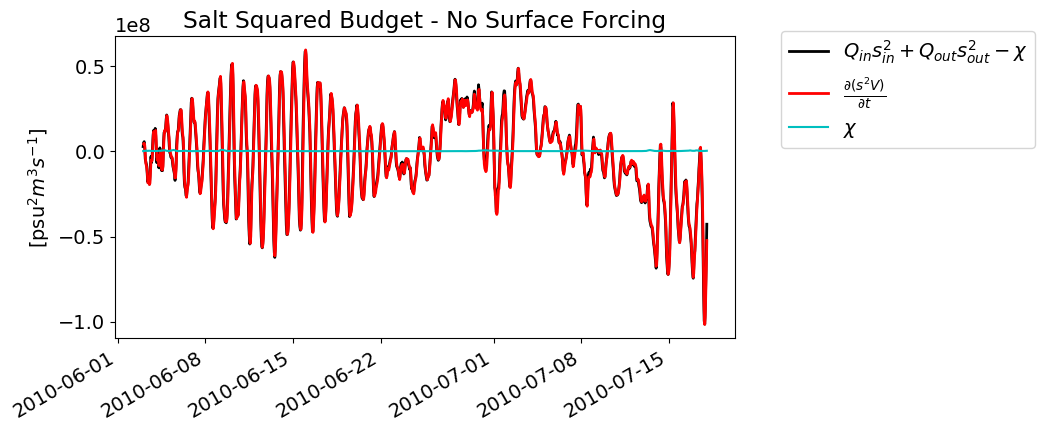

In [17]:
fig = plt.subplots(1, figsize = (8,4), dpi = 100)


# (tef.ssaltadv).plot(lw=2, color='r', label=r'$Q_{in}s^2_{in}+Q_{out}s^2_{out}$')
(tef_hourly.ssaltadv-chi_hourly.chi).plot(lw=2, color='k', label=r'$Q_{in}s^2_{in}+Q_{out}s^2_{out}-\chi$')
tendencies_hourly.dssVdt.plot(lw=2, color='r', label=r'$\frac{\partial (s^2V)}{\partial t}$')
chi_hourly.chi.plot(lw = 1.5, color = 'c', label = '$\chi$')

plt.xlabel('')
plt.ylabel(r'[psu$^2 m^3 s^{-1}$]')
plt.legend(bbox_to_anchor=(1.5, 1.05))
plt.title('Salt Squared Budget - No Surface Forcing')

Text(0.5, 1.0, 'Salt Variance Budget - No Surface Forcing')

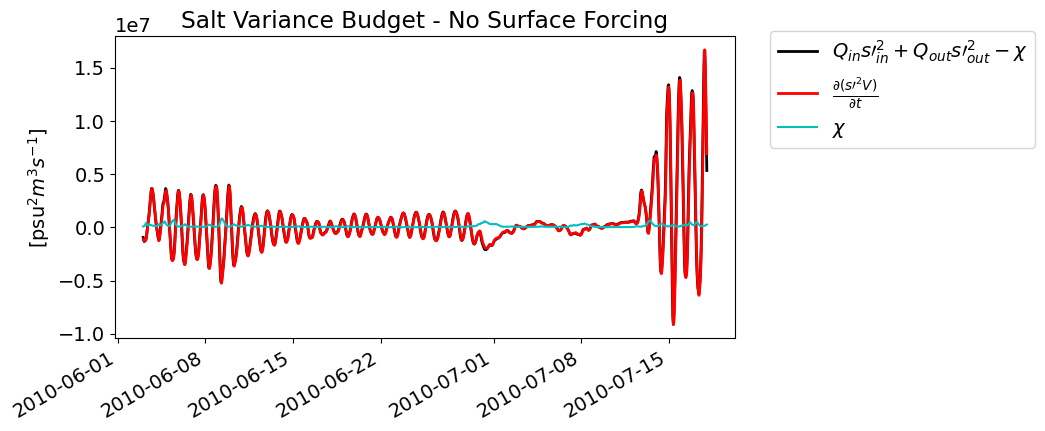

In [18]:
fig = plt.subplots(1, figsize = (8,4), dpi = 100)

(tef_hourly.svaradv-chi_hourly.chi).plot(lw=2, color='k', label=r'$Q_{in}s \prime^2_{in}+Q_{out}s \prime^2_{out}-\chi$')
# (tef.ssaltadv).plot(lw=2, color='r', label=r'$Q_{in}s^2_{in}+Q_{out}s^2_{out}$')
tendencies_hourly.dsvardt.plot(lw=2, color='r', label=r'$\frac{\partial (s \prime^2V)}{\partial t}$')
chi_hourly.chi.plot(lw = 1.5, color = 'c', label = '$\chi$')

plt.xlabel('')
plt.ylabel(r'[psu$^2 m^3 s^{-1}$]')
plt.legend(bbox_to_anchor=(1.5, 1.05))
plt.title('Salt Variance Budget - No Surface Forcing')

### Plot histograms of volume and salinity variance transport. Note we omit salinity and salinity squared because the trends are identical, only the magnitude changes.

Text(0.5, 1.0, 'S$^\\prime{^2}$ Transport [(g kg$^{-1}$)$^2$ m$^3$ s$^{-1}]$')

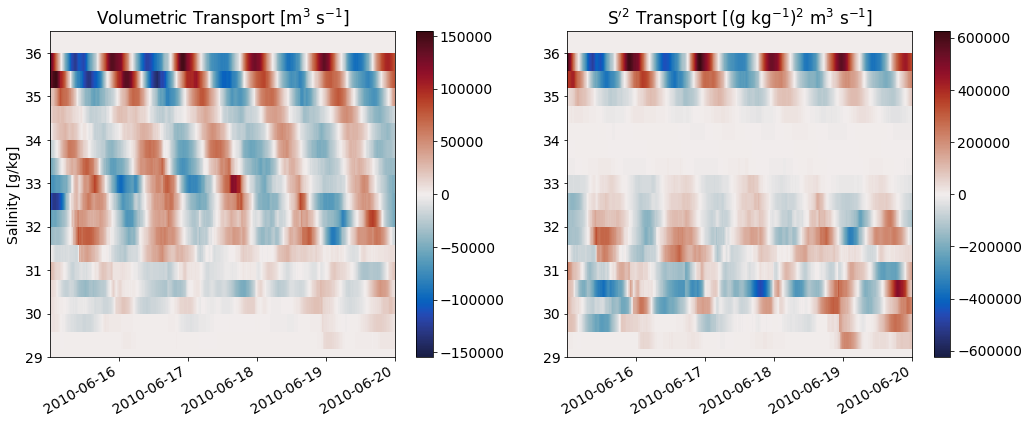

In [19]:
fig, ax = plt.subplots(1,2, figsize = (17,6))

tef_10min.Qnet.plot(y = 'salt_bin', 
                    cmap = cmo.balance,
                    ax = ax[0],
                    cbar_kwargs = {'label': ''})

tef_10min.Qsvarnet.plot(y = 'salt_bin', 
                    cmap = cmo.balance,
                    ax = ax[1],
                    cbar_kwargs = {'label': ''})

ax[0].set_xlabel('')
ax[0].set_ylabel('Salinity [g/kg]')
ax[0].set_ylim(29,36.5)
ax[0].set_title('Volumetric Transport [m$^3$ s$^{-1}]$')

ax[1].set_xlabel('')
ax[1].set_ylabel('')
ax[1].set_ylim(29,36.5)
ax[1].set_title('S$^\prime{^2}$ Transport [(g kg$^{-1}$)$^2$ m$^3$ s$^{-1}]$')

Text(0.5, 1.0, 'S$^\\prime{^2}$ Transport [(g kg$^{-1}$)$^2$ m$^3$ s$^{-1}]$')

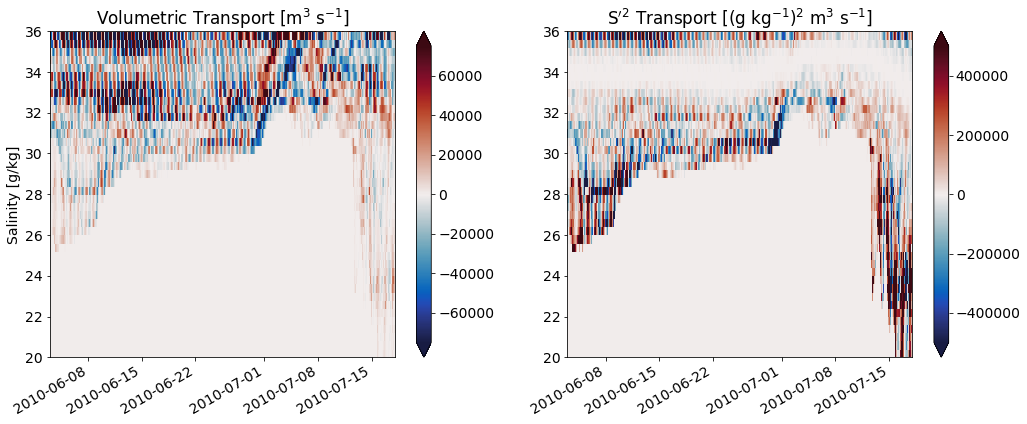

In [20]:
fig, ax = plt.subplots(1,2, figsize = (17,6))

tef_hourly.Qnet.plot(y = 'salt_bin', 
                    cmap = cmo.balance,
                    ax = ax[0],
                    cbar_kwargs = {'label': ''},
                    vmin = -.75e5,
                    vmax = .75e5)

tef_hourly.Qsvarnet.plot(y = 'salt_bin', 
                    cmap = cmo.balance,
                    ax = ax[1],
                    cbar_kwargs = {'label': ''},
                    vmin = -5e5,
                    vmax = 5e5)

ax[0].set_xlabel('')
ax[0].set_ylabel('Salinity [g/kg]')
ax[0].set_ylim(20,36)
ax[0].set_title('Volumetric Transport [m$^3$ s$^{-1}]$')

ax[1].set_xlabel('')
ax[1].set_ylabel('')
ax[1].set_ylim(20,36)
ax[1].set_title('S$^\prime{^2}$ Transport [(g kg$^{-1}$)$^2$ m$^3$ s$^{-1}]$')

### Directly compare different number of salinity bins

Text(0.5, 1.0, 'Volumetric Transport - 200 bins [m$^3$ s$^{-1}]$')

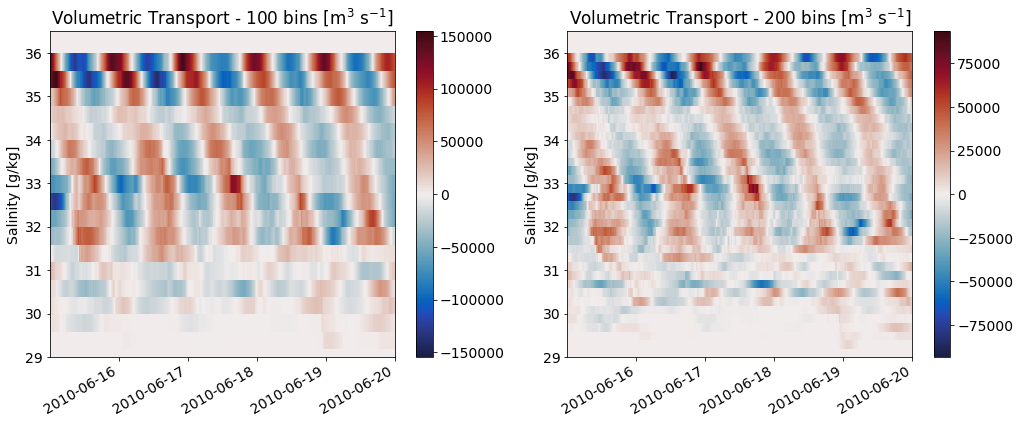

In [4]:
fig, ax = plt.subplots(1,2, figsize = (17,6))

tef_10min.Qnet.plot(y = 'salt_bin', 
                    cmap = cmo.balance,
                    ax = ax[0],
                    cbar_kwargs = {'label': ''})

tef_10min_s200.Qnet.plot(y = 'salt_bin', 
                        cmap = cmo.balance,
                        ax = ax[1],
                        cbar_kwargs = {'label': ''})

ax[0].set_xlabel('')
ax[0].set_ylabel('Salinity [g/kg]')
ax[0].set_ylim(29,36.5)
ax[0].set_title('Volumetric Transport - 100 bins [m$^3$ s$^{-1}]$')

ax[1].set_xlabel('')
ax[1].set_ylabel('Salinity [g/kg]')
ax[1].set_ylim(29,36.5)
ax[1].set_title('Volumetric Transport - 200 bins [m$^3$ s$^{-1}]$')

### Analyze the surface tracer fluxes. 

In [222]:
xislice=slice(50,251) #note tendencies have x+1 stopping points
etaslice=slice(150,351)

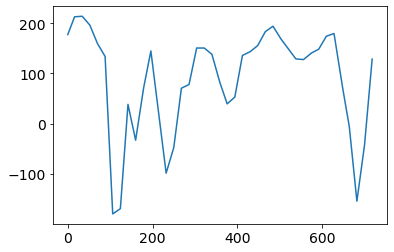

In [233]:
dss = xr.open_dataset('/scratch/user/dylan.schlichting/TXLA_Outputs/txla2_frc_ERAI_nest.nc')

dss = dss.sel(time = slice('2010-06-15 00:00:00', '2010-06-20 00:00:00')) \
         .isel(xi_rho = xislice, eta_rho = etaslice)

swflux = dss.swflux.resample(time = '10min').interpolate('linear')

#hourly resampling 
# dss = dss.sel(time = slice('2010-06-02 23:00:00', '2010-07-18 00:00:00')) \
#          .isel(xi_rho = xislice, eta_rho = etaslice)

# swflux = dss.swflux.resample(time = '1h').interpolate('linear') #one extra time step at beginning, cut it.

swflux = (swflux[2:]/100)/86400 #convert from cm/d to m/s
dA = (ds.dx*ds.dy).isel(eta_rho = etaslice, xi_rho = xislice)
swflux = (swflux*dA).sum(dim = ['eta_rho','xi_rho']).load()

plt.plot(swflux)

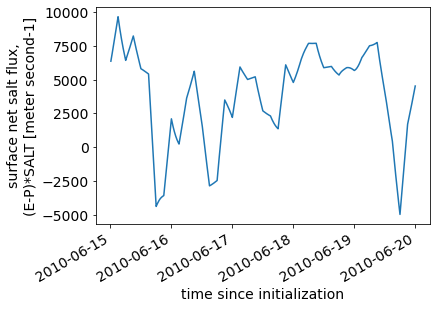

In [245]:
paths = ['/scratch/user/dylan.schlichting/TXLA_Outputs/nested_10min/ocean_his_child_00001.nc',
         '/scratch/user/dylan.schlichting/TXLA_Outputs/nested_10min/ocean_his_child_00002.nc',
         '/scratch/user/dylan.schlichting/TXLA_Outputs/nested_10min/ocean_his_child_00003.nc',
         '/scratch/user/dylan.schlichting/TXLA_Outputs/nested_10min/ocean_his_child_00004.nc',
         '/scratch/user/dylan.schlichting/TXLA_Outputs/nested_10min/ocean_his_child_00005.nc',
        ]
ds = xroms.open_mfnetcdf(paths, 
                         chunks = {'ocean_time':1})
ds, grid = xroms.roms_dataset(ds, 
                              Vtransform = None)
ssflux = (ds.ssflux.isel(eta_rho = etaslice, xi_rho = xislice)*dA).sum(['eta_rho', 'xi_rho']).load()
ssflux.plot()

### Redo the volume budget with surface forcing

In [251]:
sss = ds.salt.isel(eta_rho = etaslice, xi_rho = xislice, s_rho = -1)
svolflux = ((ds.ssflux.isel(eta_rho = etaslice, xi_rho = xislice)/sss)*dA).sum(['eta_rho', 'xi_rho']).load()

# ssflux/(ds.salt.isel(eta_rho = etaslice, xi_rho = xislice, s_rho = -1))

Text(0.5, 1.0, 'Volume Budget - No Surface Forcing')

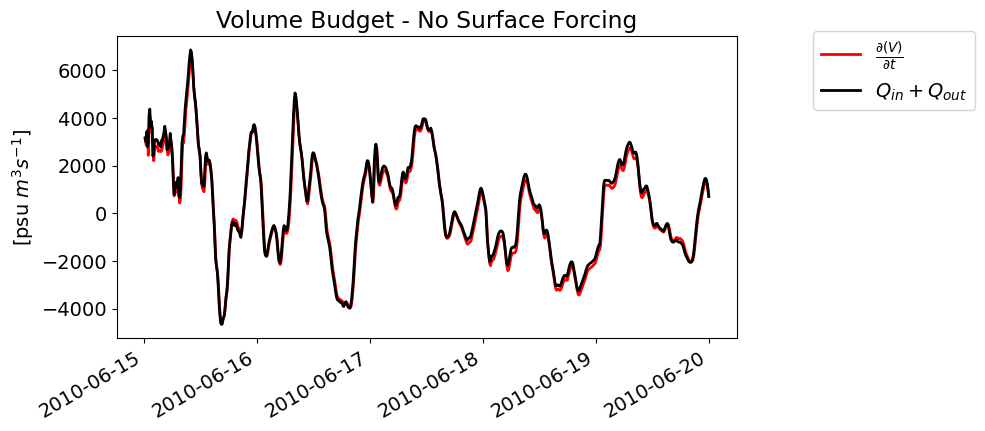

In [254]:
fig = plt.subplots(1, figsize = (8,4), dpi=100)

(tendencies_10min.dVdt).plot(lw=2, color='r', label=r'$\frac{\partial (V)}{\partial t}$')
(tef_10min.voladv[1:]+svolflux).plot(lw=2, color='k', label = r'$Q_{in}+Q_{out}$')

plt.xlabel('')
plt.ylabel(r'[psu $m^3 s^{-1}$]')
plt.legend(bbox_to_anchor=(1.4, 1.05))
plt.title('Volume Budget - No Surface Forcing')

### Redo the salt budget with surface forcing

Text(0.5, 1.0, 'Salt Budget - No Surface Forcing')

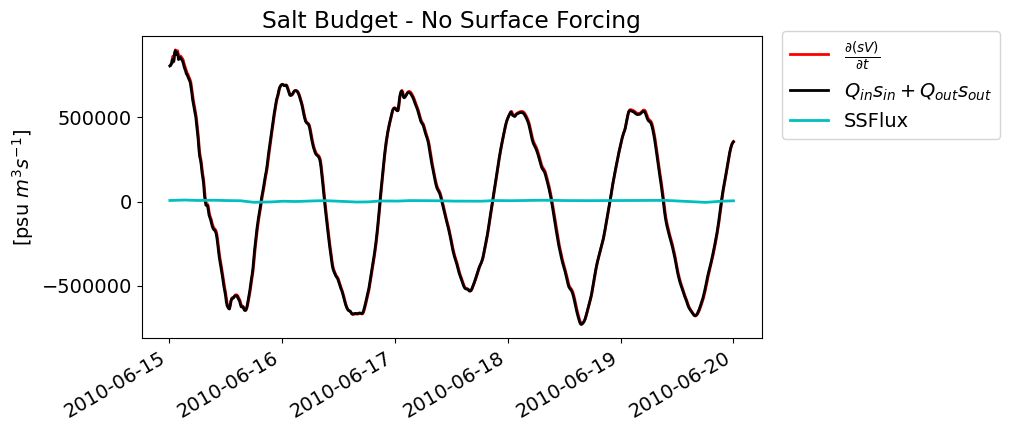

In [225]:
fig = plt.subplots(1, figsize = (8,4), dpi=100)

(tendencies_10min.dsVdt).plot(lw=2, color='r', label=r'$\frac{\partial (sV)}{\partial t}$')
(tef_10min.saltadv).plot(lw=2, color='k', label = r'$Q_{in}s_{in}+Q_{out}s_{out}$')
ssflux.plot(lw=2, color = 'c', label = 'SSFlux')

plt.xlabel('')
plt.ylabel(r'[psu $m^3 s^{-1}$]')
plt.legend(bbox_to_anchor=(1.4, 1.05))
plt.title('Salt Budget - No Surface Forcing')

In [229]:
bulk_stats(tef_10min.saltadv+ssflux, tendencies_10min.dsVdt)

12065431.04086164 tef sum [m^3/s]
11471516.493058264 tendency sum [m^3/s]
5.177297597599848 Percent difference


In [330]:
xr.open_mfdataset('/scratch/user/dylan.schlichting/tef/outputs/histograms/xi_50_250_eta_150_350/Hourly/Qsvarh_nested_hourly_xi_50250_eta150350_da.nc')

<xarray.Dataset>
Dimensions:     (ocean_time: 432, salt_bin: 100)
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2010-06-15T00:10:00 ... 2010-06-18
  * salt_bin    (salt_bin) float64 0.2 0.6 1.0 1.4 1.8 ... 38.6 39.0 39.4 39.8
Data variables:
    QsvarWh     (ocean_time, salt_bin) float64 dask.array<chunksize=(432, 100), meta=np.ndarray>
    QsvarEh     (ocean_time, salt_bin) float64 dask.array<chunksize=(432, 100), meta=np.ndarray>
    QsvarNh     (ocean_time, salt_bin) float64 dask.array<chunksize=(432, 100), meta=np.ndarray>
    QsvarSh     (ocean_time, salt_bin) float64 dask.array<chunksize=(432, 100), meta=np.ndarray>
Attributes:
    Description:    Salinity variance transport weighted histograms
    Author:         Dylan Schlichting
    Created:        2021-01-18T09:06:48.263011
    Grid:           xi points: slice(50, 250, None), eta points: slice(150, 3...
    Salinity Bins:  100
    Qsvarh units:   (g/kg)^2 m^3 s^-1

In [316]:
xr.open_dataset('/scratch/user/dylan.schlichting/tef/outputs/histograms/Qsvarh_nested_hourly_xi_50250_eta150350_da.nc')

<xarray.Dataset>
Dimensions:     (ocean_time: 1080, salt_bin: 100)
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2010-06-03T01:00:00 ... 2010-07-18
  * salt_bin    (salt_bin) float64 0.2 0.6 1.0 1.4 1.8 ... 38.6 39.0 39.4 39.8
Data variables:
    QsvarWh     (ocean_time, salt_bin) float64 ...
    QsvarEh     (ocean_time, salt_bin) float64 ...
    QsvarNh     (ocean_time, salt_bin) float64 ...
    QsvarSh     (ocean_time, salt_bin) float64 ...
Attributes:
    Description:    Salinity variance transport weighted histograms
    Author:         Dylan Schlichting
    Created:        2021-01-18T12:10:09.411452
    Grid:           xi points: slice(50, 250, None), eta points: slice(150, 3...
    Salinity Bins:  100
    Qsvarh units:   (g/kg)^2 m^3 s^-1

Text(0.5, 1.0, 'Volume Budget - No Surface Forcing')

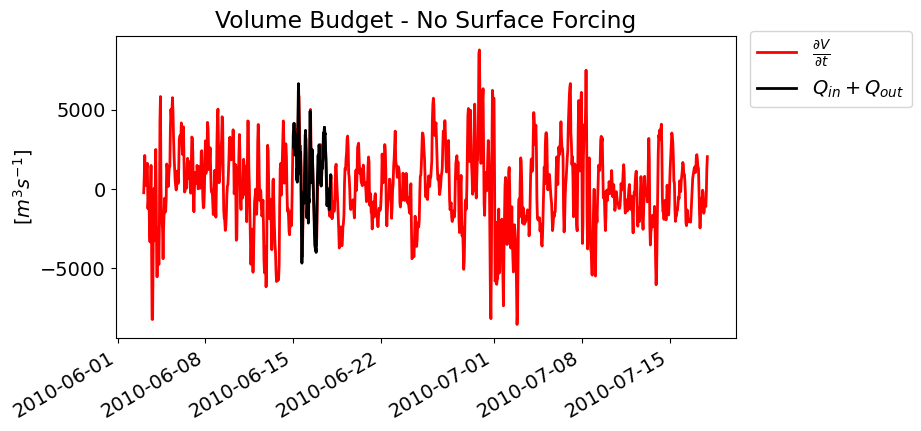

In [283]:
fig = plt.subplots(1, figsize = (8,4), dpi=100)

(tendencies_hourly.dVdt).plot(lw=2, color='r', label=r'$\frac{\partial V}{\partial t}$')
tef_hourly.voladv.plot(lw=2, color='k', label=r'$Q_{in}+Q_{out}$')

plt.xlabel('')
plt.ylabel(r'[$m^3 s^{-1}$]')
plt.legend(bbox_to_anchor=(1.3, 1.05))
plt.title('Volume Budget - No Surface Forcing')

### Directly compare the budgets during the overlap period

In [293]:
print(ds_10min.ocean_time[0].values)
print(ds_10min.ocean_time[-1].values)

2010-06-15T00:10:00.000000000
2010-06-20T00:00:00.000000000


In [307]:
ds_hourly.sel(ocean_time = slice('2010-6-15 0:10:00.000000000', 
                                 '2010-6-20 0:00:00.000000000'))

<xarray.Dataset>
Dimensions:         (eta_rho: 602, eta_v: 601, ocean_time: 120, s_rho: 30, s_w: 31, tracer: 3, xi_rho: 677, xi_u: 676)
Coordinates:
  * s_rho           (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
  * s_w             (s_w) float64 -1.0 -0.9667 -0.9333 ... -0.06667 -0.03333 0.0
    lon_rho         (eta_rho, xi_rho) float64 dask.array<chunksize=(602, 677), meta=np.ndarray>
    lat_rho         (eta_rho, xi_rho) float64 dask.array<chunksize=(602, 677), meta=np.ndarray>
    lon_u           (eta_rho, xi_u) float64 dask.array<chunksize=(602, 676), meta=np.ndarray>
    lat_u           (eta_rho, xi_u) float64 dask.array<chunksize=(602, 676), meta=np.ndarray>
    lon_v           (eta_v, xi_rho) float64 dask.array<chunksize=(601, 677), meta=np.ndarray>
    lat_v           (eta_v, xi_rho) float64 dask.array<chunksize=(601, 677), meta=np.ndarray>
    lon_psi         (eta_v, xi_u) float64 dask.array<chunksize=(601, 676), meta=np.ndarray>
    lat_psi         (eta_v, xi_u) float64 dask.array<chunksize=(601, 676), meta=np.ndarray>
  * ocean_time      (ocean_time) datetime64[ns] 2010-06-15T01:00:00 ... 2010-...
  * xi_rho          (xi_rho) int64 0 1 2 3 4 5 6 ... 670 671 672 673 674 675 676
  * xi_u            (xi_u) int64 0 1 2 3 4 5 6 7 ... 669 670 671 672 673 674 675
  * eta_rho         (eta_rho) int64 0 1 2 3 4 5 6 ... 596 597 598 599 600 601
  * eta_v           (eta_v) int64 0 1 2 3 4 5 6 ... 594 595 596 597 598 599 600
    z_w             (ocean_time, s_w, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 31, 602, 677), meta=np.ndarray>
    z_w_u           (ocean_time, s_w, eta_rho, xi_u) float64 dask.array<chunksize=(1, 31, 602, 676), meta=np.ndarray>
    z_w_v           (ocean_time, s_w, eta_v, xi_rho) float64 dask.array<chunksize=(1, 31, 601, 677), meta=np.ndarray>
    z_w_psi         (ocean_time, s_w, eta_v, xi_u) float64 dask.array<chunksize=(1, 31, 601, 676), meta=np.ndarray>
    z_rho           (ocean_time, s_rho, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 30, 602, 677), meta=np.ndarray>
    z_rho_u         (ocean_time, s_rho, eta_rho, xi_u) float64 dask.array<chunksize=(1, 30, 602, 676), meta=np.ndarray>
    z_rho_v         (ocean_time, s_rho, eta_v, xi_rho) float64 dask.array<chunksize=(1, 30, 601, 677), meta=np.ndarray>
    z_rho_psi       (ocean_time, s_rho, eta_v, xi_u) float64 dask.array<chunksize=(1, 30, 601, 676), meta=np.ndarray>
    z_rho0          (s_rho, eta_rho, xi_rho) float64 dask.array<chunksize=(30, 602, 677), meta=np.ndarray>
    z_rho_u0        (s_rho, eta_rho, xi_u) float64 dask.array<chunksize=(30, 602, 676), meta=np.ndarray>
    z_rho_v0        (s_rho, eta_v, xi_rho) float64 dask.array<chunksize=(30, 601, 677), meta=np.ndarray>
    z_rho_psi0      (s_rho, eta_v, xi_u) float64 dask.array<chunksize=(30, 601, 676), meta=np.ndarray>
    z_w0            (s_w, eta_rho, xi_rho) float64 dask.array<chunksize=(31, 602, 677), meta=np.ndarray>
    z_w_u0          (s_w, eta_rho, xi_u) float64 dask.array<chunksize=(31, 602, 676), meta=np.ndarray>
    z_w_v0          (s_w, eta_v, xi_rho) float64 dask.array<chunksize=(31, 601, 677), meta=np.ndarray>
    z_w_psi0        (s_w, eta_v, xi_u) float64 dask.array<chunksize=(31, 601, 676), meta=np.ndarray>
Dimensions without coordinates: tracer
Data variables:
    ntimes          int32 ...
    ndtfast         int32 ...
    dt              float64 ...
    dtfast          float64 ...
    dstart          datetime64[ns] ...
    shuffle         int32 ...
    deflate         int32 ...
    deflate_level   int32 ...
    nHIS            int32 ...
    ndefHIS         int32 ...
    nRST            int32 ...
    Falpha          float64 ...
    Fbeta           float64 ...
    Fgamma          float64 ...
    nl_tnu2         (tracer) float64 dask.array<chunksize=(3,), meta=np.ndarray>
    nl_visc2        float64 ...
    LuvSponge       int32 ...
    LtracerSponge   (tracer) int32 dask.array<chunksize=(3,), meta=np.ndarray>
    Akt_bak         (tracer) float64 das